# What behaviors are associated with learning in Interactive Radio Instruction?   

This is analysis seeks to perform a correlation analysis to identify what learner behavior may be associated with measures of learning e.g earning a certificate of completion.

In [180]:
#Importing Libraries
import pandas as pd

#viz
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline

pd.set_option('display.max_columns', 1000) #show columns in scrollable table
pd.set_option('display.max_rows', 500)
pd.set_option("max_colwidth", None) #don't truncate data in columns.
pd.set_option('display.max_columns', 1000) #show columns in scrollable table
pd.set_option('display.max_rows', 500)
pd.set_option("max_colwidth", None) #don't truncate data in columns.

#read file from data folder, return file
def read_data(file_name, folder="/Users/ddbutler/Desktop/Repos/Yiya-Solutions-Analysis/yiya-completion-analysis/course3_data_v2_pickle/"):
    #combine foler and file name to get the full path
    df = pd.read_pickle(folder + file_name)
    return df

response_df = read_data(file_name="response.pkl")
response_df.sample(3, random_state=5) #See sample of data

,created,updated,user_id,source_id,key,value,correct
id,,,,,,,
350758,2021-07-21 10:10:49,2021-07-21 10:10:49,38080,689443,profile/access#internet,No,0
1326640,2022-10-12 05:30:04,2022-10-12 05:30:04,60765,2634967,airscience-2022a/course/tests/step-1-test#q1-what-are-the-first-2-steps-of-the-engineering-process,"Identify, investigate",1
1139735,2022-07-12 22:51:44,2022-07-12 22:51:44,53007,2290362,course-menu,My Profile,0


In [181]:
# Getting learners registered with Lira section
registration_df = read_data(file_name="registration.pkl")
registration_df.sample(3, random_state=5) #See sample of data

,created,updated,course_id,user_id
id,,,,
68167,2022-09-20 12:00:24,2022-09-20 12:00:24,5,62814
41133,2021-07-08 06:00:26,2021-07-08 06:00:26,3,32204
40410,2021-07-07 02:39:43,2021-07-07 02:39:43,3,30940


# Sampling Method 

Which course learners should we use for this analysis?
Course 3 Lira learners that completed the baseline survey will be used for this analysis. 

In [182]:
print("Number of Users Register for Course Sections")
print(registration_df["course_id"].value_counts())

Number of Users Register for Course Sections
3    17950
2    10834
5     2754
4     1417
Name: course_id, dtype: int64


## Restrict to Lira Course 3

In [183]:
#Get user ids
is_lira_id_5 = registration_df["course_id"] == 5
lira_learners_ids = registration_df.loc[is_lira_id_5, "user_id"]
print("Total Lira Learners", len(lira_learners_ids))

Total Lira Learners 2754


In [184]:
#Restrict to user_ids
lira_responses = response_df[response_df["user_id"].isin(lira_learners_ids)]

#Restrict to dates
#TODO: Exam questions are listed outside of this time. What was the exam in course 3?
is_course_3_date = (lira_responses["created"] >= "2022-08-11") & (lira_responses["created"] <= "2022-12-29") 
lira_responses = lira_responses.loc[is_course_3_date]

lira_responses.sample(3)

,created,updated,user_id,source_id,key,value,correct
id,,,,,,,
1328766,2022-10-12 18:13:42,2022-10-12 18:13:42,62017,2638967,airscience-2022a/course/step-2-investigate/step-2-lesson-2/go-to-questions#q2-what-are-the-most-common-types-of-washing-machines,All the above,1
1223282,2022-09-20 14:40:05,2022-09-20 14:40:05,63372,2432888,profile/gender,Male,0
1178691,2022-09-14 19:18:44,2022-09-14 19:18:44,28698,2355183,airscience-2022a/course/baseline-survey#question-10-when-facing-a-new-problem-lesson-objectives-baseline-survey-objectives-md-10-creativity-and-ego-resilience,Ask questions,0


## Restrict to Baseline Completers

In [185]:
#Get People who have compleed the last question on the baseline

#Get responses to last baseline question then save those user ids
is_last_baseline_question = lira_responses["key"] == "airscience-2022a/course/baseline-survey#question-10-when-facing-a-new-problem-lesson-objectives-baseline-survey-objectives-md-10-creativity-and-ego-resilience"
users_completed_baseline_ids = lira_responses[is_last_baseline_question]["user_id"].unique()

#Restrict responses to users that completed last baseline question
lira_responses = lira_responses[lira_responses["user_id"].isin(users_completed_baseline_ids)]
print("Lira users that completed baseline: ", lira_responses["user_id"].nunique())

Lira users that completed baseline:  1552


## Remove Testers

In [186]:
data_pkl_folder = "/Users/ddbutler/Desktop/Repos/Yiya-Solutions-Analysis/yiya-completion-analysis/course3_data_v2_pickle/"
user_df = pd.read_pickle(data_pkl_folder + "user.pkl")

#Get list of testers
tester_ids = user_df.query("tester == 1").index

#Create bool mask 
is_response_from_tester = lira_responses["user_id"].isin(tester_ids)

# Locate responses that are NOT from testers
lira_responses = lira_responses.loc[~is_response_from_tester]

print("user count after removing testers: ", lira_responses["user_id"].nunique())

user count after removing testers:  1545


## Restrict to Paid Users

In [187]:
#Paid Users
data_pkl_folder = "/Users/ddbutler/Desktop/Repos/Yiya-Solutions-Analysis/yiya-completion-analysis/course3_data_v2_pickle/"
payments_df = pd.read_pickle(data_pkl_folder + "payments.pkl")

#get paid user ids based on last payment entry
paid_user_payments = payments_df.query("payment_stage == 'paid'").drop_duplicates(subset=["user_id"], keep="last")
is_response_from_paid_user = lira_responses["user_id"].isin(paid_user_payments["user_id"])

# Restrict to responses from user_ids in paid status in payment table
lira_responses = lira_responses.loc[is_response_from_paid_user]
num_of_paid_lira_users = lira_responses["user_id"].nunique()
print("number of paid lira users ", num_of_paid_lira_users)
lira_responses.sample(4)


number of paid lira users  411


,created,updated,user_id,source_id,key,value,correct
id,,,,,,,
1284134,2022-09-30 11:01:51,2022-09-30 11:01:51,58492,2552753,airscience-2022a/course/intro-step/intro-step-lesson-3/go-to-questions#what-is-engineering,The process of using science and mathematics to simplify life,1
1183453,2022-09-15 09:43:35,2022-09-15 09:43:35,59049,2362386,airscience-2022a/course/baseline-survey#question-5-generally-earn-per-week,I don’t earn any money,0
1489913,2022-11-26 12:09:43,2022-11-26 12:09:43,17165,2918698,airscience-2022a/course/step-7-improve/step-7-lesson-3/go-to-questions#q1-on-the-schematic-diagram-of-the-improved-washing-machine-what-is-the-biggest-change,Adding a pedal that can be turned by the bicycle wheel,1
1558267,2022-12-23 18:19:21,2022-12-23 18:19:21,27213,3026492,airscience-2022a/course/tests/step-7-test#q5-how-does-frictional-force-help-the-working-of-the-pedal-unit,Wears out the tyres of the machine,0


## Show Payment Type Distributions

Raw Counts
scholarship     263
mobile-money    148
Name: payment_type, dtype: int64
Total:  411

Percentages %
scholarship     0.639903
mobile-money    0.360097
Name: payment_type, dtype: float64


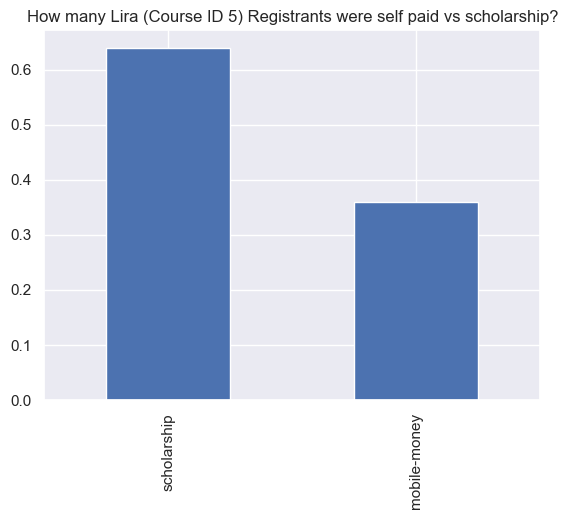

In [188]:
#Keep last payment record of each user
payments_no_duplicates_df = payments_df.drop_duplicates(subset="user_id", keep="last")

# Check if user_id from response table is present in payments table
is_paid_lira_learner = payments_no_duplicates_df["user_id"].isin(lira_responses["user_id"])
lira_payments = payments_no_duplicates_df.loc[is_paid_lira_learner, "payment_type"]

print("Raw Counts")
print(lira_payments.value_counts())
print("Total: ", lira_payments.value_counts().sum())

print("")
print("Percentages %")
print(lira_payments.value_counts(normalize=True))

# Plot Payment Types
lira_payments.value_counts(normalize=True).plot.bar()
plt.title("How many Lira (Course ID 5) Registrants were self paid vs scholarship?")
plt.show()

# Feature Engineering
The following features are of interest for this analysis:
- Explanatory Variables (Measures of Participation)
    - num_practice_questions_during_broadcast = total number of unique lesson questions attempted for the first time during radio broadcast time (11:15 a.m - 11:45 am UTC)
    - num_practice_questions_before-after_broadcast = total number of unique lesson questions attempted for the first time outside radio broadcast time 
- Outcomes (Measures of Learning)
    - num_correct_test_questions = total number of test questions done correctly on first attempt throughout the course
    - num_correct_exam_questions = total number of final exam questions done correctly on first attempt

Why do I specify the "first time" for measures of participation? - This system is held together with digital ductape and a dream so we have discovered bugs that may enable users to access questions, when they are not supposed to access them.

## Extract Info from Key

In [189]:
def get_step(keys):
    # step questions follow this regex pattern
    step_pattern = r"((?<=step-)\d{1,2}|baseline|intro-step|endline|course-menu|exam-questions)"
    step_column = keys.str.extract(step_pattern)
    return step_column

def get_lesson_number(keys):
    lesson_pattern = r"(?<=lesson-)([\d{1,2}])"
    lesson_column = keys.str.extract(lesson_pattern)
    return lesson_column

def get_question_number(keys):
    question_pattern = r"(?<=q)([\d{1,2}])"
    question_column = keys.str.extract(question_pattern)
    return question_column

def expand_question_keys(df):
    #Label step, lesson, and question
    df["step_num"] = get_step(df["key"])
    df["lesson_num"] = get_lesson_number(df["key"])
    df["question_num"] = get_question_number(df["key"])
    return df

In [190]:
# Expanding Keys to label steps, lessons, and question numbers
lira_responses_expanded = expand_question_keys(lira_responses)
#drop non step questions
#lira_responses_to_assessments = lira_responses_to_assessments.dropna
lira_responses_expanded.sample(5, random_state=3)

,created,updated,user_id,source_id,key,value,correct,step_num,lesson_num,question_num
id,,,,,,,,,,
1354012,2022-10-19 05:50:20,2022-10-19 05:50:20,68415,2684070,airscience-2022a/course/step-2-investigate/step-2-lesson-1/go-to-questions#q2-why-was-it-easy-to-slide-off-the-ground-without-shoes-on,All the above,1,2,1,2
1264909,2022-09-27 05:55:11,2022-09-27 05:55:11,62855,2512714,airscience-2022a/course/intro-step/intro-step-lesson-1/go-to-questions#what-makes-a-pen-a-cup-a-paper-etc-a-technology,They all simplify life or solve a problem,1,intro-step,1,NaN
1327306,2022-10-12 09:43:51,2022-10-12 09:43:51,66598,2636181,airscience-2022a/course/step-1-identify/step-1-lesson-1/go-to-questions#how-is-work-divided-among-boys-and-girls-at-home,Girls do most of the work,1,1,1,NaN
1335911,2022-10-15 03:18:39,2022-10-15 03:18:39,59435,2653051,tech-team-static/static-pages/my-course,Previous Lessons,0,NaN,NaN,NaN
1379093,2022-10-24 12:20:02,2022-10-24 12:20:02,64622,2729404,airscience-2022a/course/step-3-brainstorm/step-3-lesson-1/go-to-questions#q2-what-does-the-outer-drum-of-a-washing-machine-look-like,All the above,0,3,1,2


## How many questions of each type are there?

In [191]:
# Calculate number of unique lesson questions done by each user

#Get boolean mask for lesson key matching. They should contain 'lesson' and 'step'
is_lesson_response = lira_responses_expanded["key"].str.contains("lesson") & lira_responses_expanded["key"].str.contains("step")

#Save lesson keys to variable
lesson_keys = lira_responses_expanded[is_lesson_response]["key"].unique()
print("num of unique lessons questions answered by learners:", len(lesson_keys))

num of unique lessons questions answered by learners: 102


In [192]:
# Calculate number of unique test questions done by each user

#Create bool mask for test key criteria. 
is_test_response = lira_responses_expanded["key"].str.contains("test") & lira_responses_expanded["key"].str.contains("step")

#query above doesn't remove keys for step-9 (exam for other course section) and step-10 (final exam)
# set criteria for extra key
is_extra_key  = lira_responses_expanded["key"].str.contains("step-10|step-9")


#Save test key to variable. Save keys that meet initial test key criteria and are not extra
test_keys = lira_responses_expanded[is_test_response & ~is_extra_key]["key"].unique()

#Remove extra keys from step-9 (exam for other course section) and step-10 (final exam)
#test_keys = test_keys.loc[~test_keys.str.contains("step-10|step-9")]

# Print Counts
print("num of unique test questions questions answered by learners: ", len(test_keys))
print("correct test questions needed to get certificate of participation: ", 0.6 * len(test_keys))

num of unique test questions questions answered by learners:  74
correct test questions needed to get certificate of participation:  44.4


In [193]:
#According to gitbook step tests from intro to step 8 had the following number of tests
print(8 + 6 + 5 + 6 + 6 + 7 + 6 + 5 + 7, "test questions in gitbook")

56 test questions in gitbook


## Define Functions for Feature Engineering

In [194]:
"""
- Explanatory Variables (Measures of Participation)
    - num_practice_questions_during_broadcast = total number of unique lesson questions attempted for the first time during radio broadcast time (11:15 a.m - 11:45 am UTC)
    - num_practice_questions_before-after_broadcast = total number of unique lesson questions attempted for the first time outside radio broadcast time 
- Outcomes (Measures of Learning)
    - num_correct_test_questions = total number of test questions done correctly on first attempt throughout the course
    - num_correct_exam_questions = total number of final exam questions done correctly on first attempt
"""

def calc_num_practice_questions_during_broadcast(single_user_responses_df):

    #include only lesson questions
    is_lesson_response = single_user_responses_df["key"].isin(lesson_keys)
    single_user_responses_df = single_user_responses_df.loc[is_lesson_response]

    # Keep only first responses
    single_user_responses_df = single_user_responses_df.drop_duplicates(subset="key", keep="first")

    #Remove Sunday responses (no broadcast on Sunday)
    is_Sunday = single_user_responses_df["created"].dt.day_name() == "Sunday"
    non_Sunday_responses = single_user_responses_df.loc[~is_Sunday].set_index("created")

    #get responses during broadcast (between 11:15 and 11:45)
    responses_during_broadcast = non_Sunday_responses.between_time(start_time="11:15", end_time="11:45", inclusive="both")

    #Get count
    responses_during_broadcast_count = len(responses_during_broadcast)
    return responses_during_broadcast_count
    

def calc_num_practice_questions_before_after_broadcast(single_user_responses_df):
    #include only lesson questions
    is_lesson_response = single_user_responses_df["key"].isin(lesson_keys)
    single_user_responses_df = single_user_responses_df.loc[is_lesson_response]

    # sort by created time
    single_user_responses_df = single_user_responses_df.sort_values(by="created")

    # Keep only first responses
    single_user_responses_df = single_user_responses_df.drop_duplicates(subset="key", keep="first")

    # Set created time as index
    single_user_responses_df = single_user_responses_df.set_index("created")

    #get responses before and after broadcast (outside 11:15 and 11:45), 
    responses_before_after_broadcast = single_user_responses_df.between_time(start_time="11:45", end_time="11:15", inclusive="neither")

    #Get count
    count_responses_before_after_broadcast = len(responses_before_after_broadcast)
    return count_responses_before_after_broadcast

def calc_num_correct_test_questions(single_user_responses_df):
    #include only test questions
    is_test_response = single_user_responses_df["key"].isin(test_keys)
    user_test_responses = single_user_responses_df.loc[is_test_response]

    # sort by created time
    single_user_responses_df = single_user_responses_df.sort_values(by="created")

    # Keep only first attempt at each question
    user_test_responses = user_test_responses.drop_duplicates(subset = ["key"], keep="first")

    # Sum correct responses
    count_of_correct_on_first_attempt = user_test_responses["correct"].sum()

    return count_of_correct_on_first_attempt

def calc_num_correct_exam_questions(single_user_responses_df):
    # keep only exam keys
    is_exam_response = single_user_responses_df["key"].str.contains("step-10-test")
    user_exam_responses = single_user_responses_df.loc[is_exam_response]

    # sort by created time
    user_exam_responses = user_exam_responses.sort_values(by="created")

    # Keep only first attempt at each question
    user_exam_responses = user_exam_responses.drop_duplicates(subset = ["key"], keep="first")

    # Sum correct responses
    count_of_correct_on_first_attempt = user_exam_responses["correct"].sum()

    return count_of_correct_on_first_attempt
    
######## Initial Aggregations

def calc_user_lessons_done(single_user_responses_df):
    """Calculates the number of unique lesson questions completed by a single user over the entire course

    Args:
        single_user_responses_df (dataframe): dataframe of responses from a single user

    Returns:
        int: number of unique lesson questions done
    """
    #drop non lesson question responses
    is_lesson_response = single_user_responses_df["key"].isin(lesson_keys)
    user_lesson_responses = single_user_responses_df.loc[is_lesson_response]

    #Only keep first attempts
    user_lesson_responses = user_lesson_responses.drop_duplicates(subset="key", keep="first")

    #return number of unique lesson keys responded to
    return user_lesson_responses["key"].nunique()

def calc_total_unique_lesson_questions_done(single_user_responses_df):

    #drop non lesson question responses
    is_lesson_response = single_user_responses_df["key"].isin(lesson_keys)
    user_lesson_responses = single_user_responses_df.loc[is_lesson_response]

    unique_lesson_questions_done = user_lesson_responses["key"].nunique()
    return unique_lesson_questions_done


def calc_user_correct_test_questions(single_user_responses_df):
    is_test_response = single_user_responses_df["key"].isin(test_keys)
    user_test_responses = single_user_responses_df.loc[is_test_response]
    #remove duplicate correct answers (We need to know how questions are selected.)
    user_test_responses = user_test_responses.drop_duplicates(subset = ["key", "correct"])

    return user_test_responses["correct"].sum()
    pass

def cal_exam_score():
    pass

def cal_user_resposes_during_broadcast(single_user_responses_df):
    """_summary_

    Args:
        single_user_responses_df (_type_): _description_

    Returns:
        _int_: _count of messages during broadcast time_
    """
    #include only lesson or test quesitons
    is_lesson_response = single_user_responses_df["key"].isin(lesson_keys)
    is_test_response = single_user_responses_df["key"].isin(test_keys)
    single_user_responses_df = single_user_responses_df.loc[is_lesson_response | is_test_response]

    #Remove Sunday responses (no broadcast on Sunday)
    is_Sunday = single_user_responses_df["created"].dt.day_name() == "Sunday"
    non_Sunday_responses = single_user_responses_df.loc[~is_Sunday].set_index("created")
    #get responses during broadcast
    responses_during_broadcast = non_Sunday_responses.between_time(start_time="11:15", end_time="11:45")

    return len(responses_during_broadcast)


## Combine Features

In [195]:
# Initialize table
lira_learner_outcomes = pd.DataFrame()
display(lira_learner_outcomes)

# Group responses by user
lira_responses_to_assessments_user_grouped = lira_responses_expanded.groupby("user_id")
"""
- Explanatory Variables (Measures of Participation)
    - num_practice_questions_during_broadcast = total number of unique lesson questions attempted for the first time during radio broadcast time (11:15 a.m - 11:45 am UTC)
    - num_practice_questions_before-after_broadcast = total number of unique lesson questions attempted for the first time outside radio broadcast time 
- Outcomes (Measures of Learning)
    - num_test_questions_correct_on_first_attempt = total number of test questions done correctly on first attempt throughout the course
    - num_exam_questions_correct_on_first_attempt = total number of final exam questions done correctly on first attempt
"""

""


'\n- Explanatory Variables (Measures of Participation)\n    - num_practice_questions_during_broadcast = total number of unique lesson questions attempted for the first time during radio broadcast time (11:15 a.m - 11:45 am UTC)\n    - num_practice_questions_before-after_broadcast = total number of unique lesson questions attempted for the first time outside radio broadcast time \n- Outcomes (Measures of Learning)\n    - num_test_questions_correct_on_first_attempt = total number of test questions done correctly on first attempt throughout the course\n    - num_exam_questions_correct_on_first_attempt = total number of final exam questions done correctly on first attempt\n'

In [196]:
# Explanatory Variables
lira_learner_outcomes["total_practice_questions_during_broadcasts"] = \
    lira_responses_to_assessments_user_grouped.apply(calc_num_practice_questions_during_broadcast)

lira_learner_outcomes["total_practice_questions_before_after_broadcasts"] = \
    lira_responses_to_assessments_user_grouped.apply(calc_num_practice_questions_before_after_broadcast)

lira_learner_outcomes["unique_lesson_questions_attempted"] = \
    lira_responses_to_assessments_user_grouped.apply(calc_total_unique_lesson_questions_done)

lira_learner_outcomes["did_more_practice_question_first_attempts_during_broadcast"] = \
    (lira_learner_outcomes["total_practice_questions_during_broadcasts"] > lira_learner_outcomes["total_practice_questions_before_after_broadcasts"]).astype("int")



# Outcomes
lira_learner_outcomes["total_test_questions_correct_on_first_attempt"] = \
    lira_responses_to_assessments_user_grouped.apply(calc_num_correct_test_questions)

lira_learner_outcomes["total_exam_questions_correct_on_first_attempt"] = \
    lira_responses_to_assessments_user_grouped.apply(calc_num_correct_exam_questions)



lira_learner_outcomes.describe()


,total_practice_questions_during_broadcasts,total_practice_questions_before_after_broadcasts,unique_lesson_questions_attempted,did_more_practice_question_first_attempts_during_broadcast,total_test_questions_correct_on_first_attempt,total_exam_questions_correct_on_first_attempt
count,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000
mean,5.875912,45.562044,51.493917,0.024331,24.824818,5.111922
std,9.915825,35.399710,39.484320,0.154262,21.291323,5.564007
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,10.500000,11.000000,0.000000,3.500000,0.000000
50%,1.000000,41.000000,44.000000,0.000000,23.000000,0.000000
75%,7.000000,82.500000,98.000000,0.000000,44.000000,11.000000
max,57.000000,98.000000,102.000000,1.000000,68.000000,15.000000


Comment on the average and the distributions. If time allows, create a boxplot to highlight distribution. 

In [197]:
lira_learner_outcomes.sample(3)

,total_practice_questions_during_broadcasts,total_practice_questions_before_after_broadcasts,unique_lesson_questions_attempted,did_more_practice_question_first_attempts_during_broadcast,total_test_questions_correct_on_first_attempt,total_exam_questions_correct_on_first_attempt
user_id,,,,,,
60097,0,21,21,0,11,11
36523,7,11,18,0,3,10
58915,0,0,0,0,0,0


# Visualize

## Time Distribution of first attempts

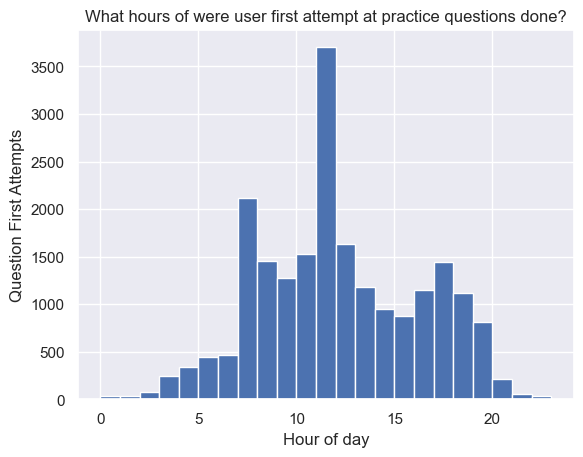

11    3702
7     2117
12    1629
10    1525
8     1455
17    1439
9     1278
13    1176
16    1148
18    1116
14     944
15     876
19     816
6      464
5      444
4      338
3      245
20     211
2       73
21      56
1       39
0       39
22      20
23      14
Name: created, dtype: int64


In [201]:
def vis_created_dist(single_user_responses_df):
    #include only lesson questions
    is_lesson_response = single_user_responses_df["key"].isin(lesson_keys)
    single_user_responses_df = single_user_responses_df.loc[is_lesson_response]

    # sort by created time
    single_user_responses_df = single_user_responses_df.sort_values(by="created")

    # Keep only first responses
    single_user_responses_df = single_user_responses_df.drop_duplicates(subset=["key","user_id"], keep="first")

    #Visualize distirbution

    import matplotlib.pyplot as plt
    #distribution of times
    #response_features["created"].dt.time
    single_user_responses_df["created"].dt.hour.hist(bins=23)

    

    plt.title("What hours of were user first attempt at practice questions done?")
    #plt.title("What hours of the day were responses sent?")
    plt.xlabel("Hour of day")
    plt.ylabel("Question First Attempts")
    plt.show()
    print(single_user_responses_df["created"].dt.hour.value_counts())

vis_created_dist(lira_responses_expanded)

# Multiple Regression Analysis

## Normalize

Normalizing with z score allows for coeefiicients to be more interperable because everything is scaled in terms of effect size.

In [145]:
## Normalize
import scipy.stats as stats

lira_learner_outcomes = stats.zscore(lira_learner_outcomes)


In [146]:
lira_learner_outcomes.describe()

,total_practice_questions_during_broadcasts,total_practice_questions_before_after_broadcasts,unique_lesson_questions_attempted,did_more_practice_question_first_attempts_during_broadcast,total_test_questions_correct_on_first_attempt,total_exam_questions_correct_on_first_attempt
count,4.110000e+02,4.110000e+02,4.110000e+02,4.110000e+02,4.110000e+02,4.110000e+02
mean,1.728814e-17,-5.186443e-17,8.644072e-17,-4.538138e-17,3.457629e-17,5.564621e-17
std,1.001219e+00,1.001219e+00,1.001219e+00,1.001219e+00,1.001219e+00,1.001219e+00
min,-5.933015e-01,-1.288643e+00,-1.305751e+00,-1.579166e-01,-1.167380e+00,-9.198681e-01
25%,-5.933015e-01,-9.916685e-01,-1.026820e+00,-1.579166e-01,-1.002794e+00,-9.198681e-01
50%,-4.923297e-01,-1.290294e-01,-1.900261e-01,-1.579166e-01,-8.581155e-02,-9.198681e-01
75%,1.135012e-01,1.044725e+00,1.179272e+00,-1.579166e-01,9.017078e-01,1.059534e+00
max,5.162091e+00,1.483116e+00,1.280702e+00,6.332456e+00,2.030301e+00,1.779316e+00


## Correlate

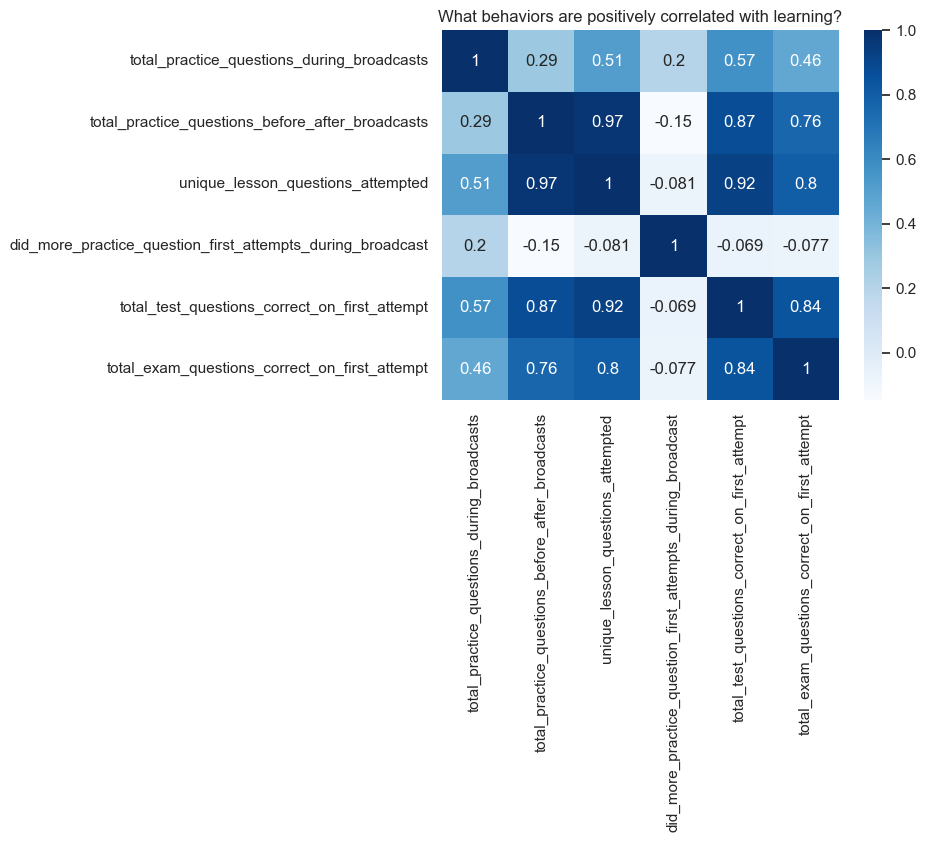

In [147]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline

corr = lira_learner_outcomes.corr()

plt.title("What behaviors are positively correlated with learning?")

sns.heatmap(corr, cmap="Blues", annot=True)
plt.show()

## Regressions against Test Performance

In [148]:
import statsmodels.api as sm

#define response variable
y = lira_learner_outcomes["total_test_questions_correct_on_first_attempt"]

#define predictor variables
x = lira_learner_outcomes[["total_practice_questions_during_broadcasts", 'total_practice_questions_before_after_broadcasts', 
                           "unique_lesson_questions_attempted"]]

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                                          OLS Regression Results                                         
Dep. Variable:     total_test_questions_correct_on_first_attempt   R-squared:                       0.867
Model:                                                       OLS   Adj. R-squared:                  0.866
Method:                                            Least Squares   F-statistic:                     887.0
Date:                                           Thu, 05 Oct 2023   Prob (F-statistic):          4.54e-178
Time:                                                   20:02:50   Log-Likelihood:                -168.09
No. Observations:                                            411   AIC:                             344.2
Df Residuals:                                                407   BIC:                             360.3
Df Model:                                                      3                                         
Covariance Type:                              

### Interpretation

TODO: Update Interpretation
For every deviattion increase in explanatory varaibles, there is a coef increase in the stand deviation of the outcome. To convert back to raw numbers, caluclaute the standard deviation for explanaotry and outcome measure. See what value the standard deviation.

e.g
STD for questions_during_broadcast is 10
STD for correct_test_questions is 5.

For every 10 questions, completed during broadcast, correct_test_questions goes up by 1.765. (coef_1 * STD_of_outcome)

**R-Squared: 0.867**

R-Squared explains that 87.7% of the variation in correct test question outcomes can be explained by the predictor variables.

**Prob (F-statistic): 2.61e-179**
The probability of the F statistic is less than 0.05. This suggests the the regression model with the current predictor variables as a whole is statistically significant.

**coef:**

***total_practice_questions_during_broadcasts***: 0.7415. For each additional practice question that is fist attempted during the broadcast time, there is a 0.74 increase in number of correct test questions.

***total_practice_questions_before_after_broadcasts***: 0.7415. For each additional practice question that is fist attempted outside the broadcast time, there is a 0.4628 increase in number of correct test questions.

const/intercept: we interpret the coefficient for the intercept to mean that a student would get  -0.6203 test questions correct. However, this result is not statically significant and a negative value is nonsensical for a count so we can ignore this.

**P>|t|**

The individual p-values tell us whether or not each predictor variable is statistically significant. total_practice_questions_during_broadcasts is statistically significant (p=0.000). total_practice_questions_before_after_broadcasts is statically significant (p=0.000).

Estimated regression equation:

total_test_questions_correct_on_first_attempt = -0.6203 + 0.7415(total_practice_questions_during_broadcasts) + 0.4628(total_practice_questions_before_after_broadcasts)

## Regressions Against Exam Performance

In [149]:
import statsmodels.api as sm

#define response variable
y = lira_learner_outcomes["total_exam_questions_correct_on_first_attempt"]

#define predictor variables
x = lira_learner_outcomes[["total_practice_questions_during_broadcasts", 'total_practice_questions_before_after_broadcasts']]

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                                          OLS Regression Results                                         
Dep. Variable:     total_exam_questions_correct_on_first_attempt   R-squared:                       0.641
Model:                                                       OLS   Adj. R-squared:                  0.639
Method:                                            Least Squares   F-statistic:                     364.4
Date:                                           Thu, 05 Oct 2023   Prob (F-statistic):           1.62e-91
Time:                                                   20:02:50   Log-Likelihood:                -372.59
No. Observations:                                            411   AIC:                             751.2
Df Residuals:                                                408   BIC:                             763.2
Df Model:                                                      2                                         
Covariance Type:                              

## Assumption Checking

Below, every assumption is passed except the Normality assumption.

#### Linearity 

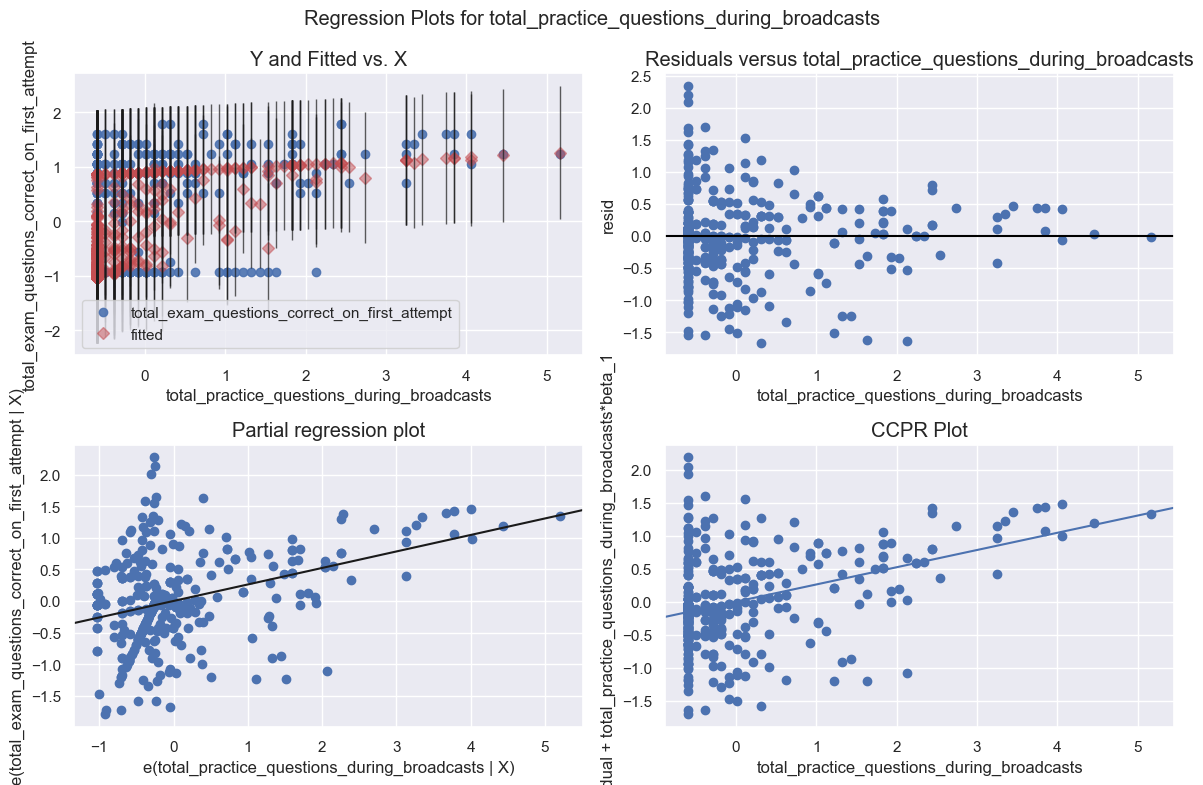

In [150]:
#define figure size
fig = plt.figure(figsize=(12,8))

#produce regression plots
fig = sm.graphics.plot_regress_exog(model, 'total_practice_questions_during_broadcasts', fig=fig)
plt.show()

Here we test for the linearity using a residual vs fitted plot (top right). The x-axis on this plot shows the actual values for the predictor variable total_practice_questions_during_broadcasts and the y-axis shows the residual for that value. Since the residuals appear to be randomly scattered around zero without any particular pattern around the line, this is an indication that non linearity is not a problem with the predictor variable. There is a linear relationship.

####  Independence of residuals

Durbin-Watson: 1.834

Linear regression assumes no correlation between residuals. The Durbin Watson test is used to measure autocorellation between residuals. The test statistic is between 0 and 4. A test stat of 2 indicates no serial correlation. Values between   1.5 and 2.5 are considered normal. Anything outside, indicates a problem with autocorelation. 

Here, the Durbin-Watson is 1.834. Thus, autocorrelation is not a problem and the residuals are independent of each other 

#### Equal Variance 

In [151]:
import statsmodels.formula.api as smf

#fit regression model
fit = smf.ols('total_test_questions_correct_on_first_attempt ~ total_practice_questions_during_broadcasts+total_practice_questions_before_after_broadcasts', data=lira_learner_outcomes).fit()

#view model summary
print(fit.summary())

                                          OLS Regression Results                                         
Dep. Variable:     total_test_questions_correct_on_first_attempt   R-squared:                       0.867
Model:                                                       OLS   Adj. R-squared:                  0.866
Method:                                            Least Squares   F-statistic:                     1327.
Date:                                           Thu, 05 Oct 2023   Prob (F-statistic):          2.61e-179
Time:                                                   20:02:50   Log-Likelihood:                -168.96
No. Observations:                                            411   AIC:                             343.9
Df Residuals:                                                408   BIC:                             356.0
Df Model:                                                      2                                         
Covariance Type:                              

In [152]:
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

#perform Bresuch-Pagan test
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(fit.resid, fit.model.exog)

lzip(names, test)

[('Lagrange multiplier statistic', 6.003951995818433),
 ('p-value', 0.11141811013399583),
 ('f-value', 3.004944880309618),
 ('f p-value', 0.11663863538255281)]

[('Lagrange multiplier statistic', 6.003951995818433),
 ('p-value', 0.11141811013399583),
 ('f-value', 3.004944880309618),
 ('f p-value', 0.11663863538255281)]

The Lagrange multiplier statistic for the test is 6.003 and the corresponding p-value is 0.1114. Because this p-value is not less than 0.05, we fail to reject the null hypothesis. We do not have sufficient evidence to say that unequal variance is present in the regression model.

#### Normality

In [153]:
import scipy.stats as stats

#perform Jarque-Bera test
print("Practice During Broadcast", stats.jarque_bera(lira_learner_outcomes["total_practice_questions_during_broadcasts"]))
print("Practice Outside Broadcast", stats.jarque_bera(lira_learner_outcomes["total_practice_questions_before_after_broadcasts"]))

Practice During Broadcast SignificanceResult(statistic=889.7725612181205, pvalue=6.142473012195808e-194)
Practice Outside Broadcast SignificanceResult(statistic=42.24850531352443, pvalue=6.696588872072494e-10)


The p value for the Jarque-Bera test of normality is less than 0.05 for both predictor variables so we **do not have a normal distribution**.

#### Multicollinearity 

Check this assumption by calculating the VIF value of each predictor variable.

In [154]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

#find design matrix for linear regression model using 'rating' as response variable 
y, X = dmatrices('total_test_questions_correct_on_first_attempt ~ total_practice_questions_during_broadcasts+total_practice_questions_before_after_broadcasts',
                 data=lira_learner_outcomes, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

#view VIF for each explanatory variable 
vif

,VIF,variable
0,1.000000,Intercept
1,1.093386,total_practice_questions_during_broadcasts
2,1.093386,total_practice_questions_before_after_broadcasts


We can observe the VIF values for each of the explanatory variables above. VIF values start at 1 and have no upper limit. A value between 1 and 5 indicates moderate correlation between a given exploratory variable and other explanatory variables, but this is not severe enough to require attention. 

Multicoloinareairty between explanatory variables is not a problem. 



# Conclusion of Multiple Linear Regression

What matters is just doing more questions.

In [155]:
#export data
lira_learner_outcomes.to_csv("/Users/ddbutler/repos_new/yiya_data_analysis/data/processed/lira_learner_outcomes.csv")

# Former Analysis

In [156]:
#TODO:
cal_user_resposes_during_broadcast(lira_responses_expanded)

6680

In [157]:
#group respones from lira to users
lira_responses_to_assessments_user_grouped = lira_responses_expanded.groupby("user_id")

## Combine Features

In [158]:
#create dataframe with features
lira_learner_outcomes = pd.DataFrame()
lira_learner_outcomes

""


In [159]:
lira_learner_outcomes["lesson_questions"] = lira_responses_to_assessments_user_grouped.apply(calc_user_lessons_done)

In [160]:
lira_learner_outcomes["correct_test_questions"] = lira_responses_to_assessments_user_grouped.apply(calc_user_correct_test_questions)

In [161]:
lira_learner_outcomes["responses_during_broadcast"] = lira_responses_to_assessments_user_grouped.apply(cal_user_resposes_during_broadcast)

In [162]:
lira_learner_outcomes.sample(4)

,lesson_questions,correct_test_questions,responses_during_broadcast
user_id,,,
58711,22,3,5
46104,20,5,0
53255,98,35,25
24325,7,0,0


In [163]:
lira_learner_outcomes.describe()

,lesson_questions,correct_test_questions,responses_during_broadcast
count,411.000000,411.000000,411.000000
mean,51.493917,26.031630,16.253041
std,39.484320,22.281053,28.817241
min,0.000000,0.000000,0.000000
25%,11.000000,3.500000,0.000000
50%,44.000000,23.000000,3.000000
75%,98.000000,46.500000,20.000000
max,102.000000,68.000000,236.000000


There is a strange outlier with the number of responses sent during broadcast. 

# Descriptive Visualizations 

## Time Distribution of Pure Responses

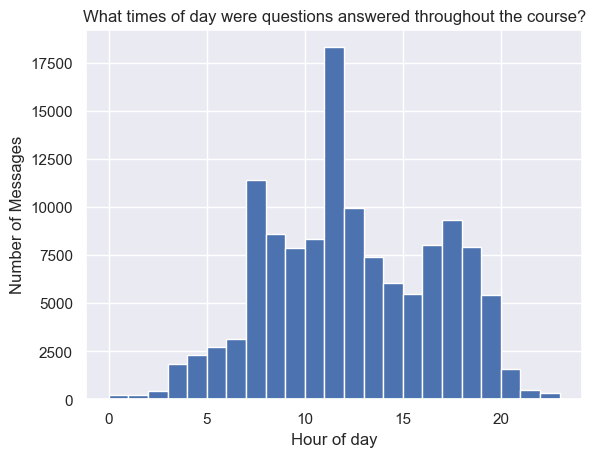

In [164]:
import matplotlib.pyplot as plt
#distribution of times
#response_features["created"].dt.time
lira_responses_expanded["created"].dt.hour.hist(bins=23)
plt.title("What times of day were questions answered throughout the course?")
#plt.title("What hours of the day were responses sent?")
plt.xlabel("Hour of day")
plt.ylabel("Number of Messages")
plt.show()

## Time Distribtuion of First Qustion Attempts

In [165]:
def visualize_created_distribution(df):

    import matplotlib.pyplot as plt
    #distribution of times
    #response_features["created"].dt.time
    lira_responses_expanded["created"].dt.hour.hist(bins=23)
    plt.title("What times of day were questions answered throughout the course?")
    #plt.title("What hours of the day were responses sent?")
    plt.xlabel("Hour of day")
    plt.ylabel("Number of Messages")
    plt.show()

lira_responses_expanded



,created,updated,user_id,source_id,key,value,correct,step_num,lesson_num,question_num
id,,,,,,,,,,
1143164,2022-08-15 16:09:49,2022-08-15 16:09:49,22945,2297542,course-menu,My Course,0,course-menu,NaN,NaN
1143295,2022-08-17 06:43:57,2022-08-17 06:43:57,22945,2297789,course-menu,My Profile,0,course-menu,NaN,NaN
1143296,2022-08-17 06:44:04,2022-08-17 06:44:04,22945,2297790,tech-team-static/static-pages/my-profile,Update my profile,0,NaN,NaN,NaN
1143297,2022-08-17 06:44:15,2022-08-17 06:44:15,22945,2297791,tech-team-static/static-pages/update-profile,More Items,0,NaN,NaN,NaN
1143298,2022-08-17 06:44:35,2022-08-17 06:44:35,22945,2297792,tech-team-static/static-pages/update-profile-cont,previous items,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1565099,2022-12-28 13:53:59,2022-12-28 13:53:59,7751,3036630,tech-team-static/static-pages/my-course,Previous Lessons,0,NaN,NaN,NaN
1565102,2022-12-28 13:54:34,2022-12-28 13:54:34,7751,3036636,airscience-2022a/course/step-8-launch/step-8-lesson-3/go-to-questions#q1-how-do-you-calculate-the-price-of-one-product,Total cost of materials + Labour + profit,1,8,3,1
1565104,2022-12-28 13:54:45,2022-12-28 13:54:45,7751,3036638,airscience-2022a/course/step-8-launch/step-8-lesson-3/go-to-questions#q2-what-do-you-need-to-start-a-business-of-making-and-selling-locally-made-washing-machines,Enough fully made samples,1,8,3,2


What percentage of messages are algined with broadcast? What's percentage of messages were sent between "start_time="11:15", end_time="11:45")"

In [166]:
len(lira_responses_expanded)

127593

In [167]:

print("Messages Sent during Hours of Day (24HR)")
print(lira_responses_expanded["created"].dt.hour.value_counts())

Messages Sent during Hours of Day (24HR)
11    18331
7     11394
12     9971
17     9328
8      8624
10     8366
16     8050
18     7941
9      7889
13     7416
14     6071
15     5460
19     5420
6      3154
5      2746
4      2317
3      1819
20     1584
21      492
2       423
0       235
1       226
22      207
23      129
Name: created, dtype: int64


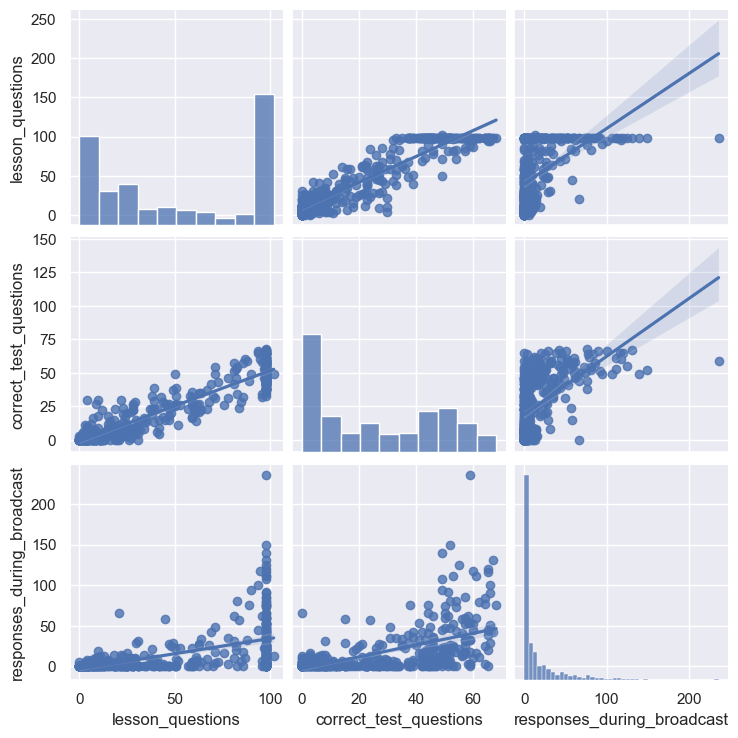

In [168]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline

sns.pairplot(data=lira_learner_outcomes, kind="reg")
plt.show()

## Active Users Over Time

Enrolled Users:   411


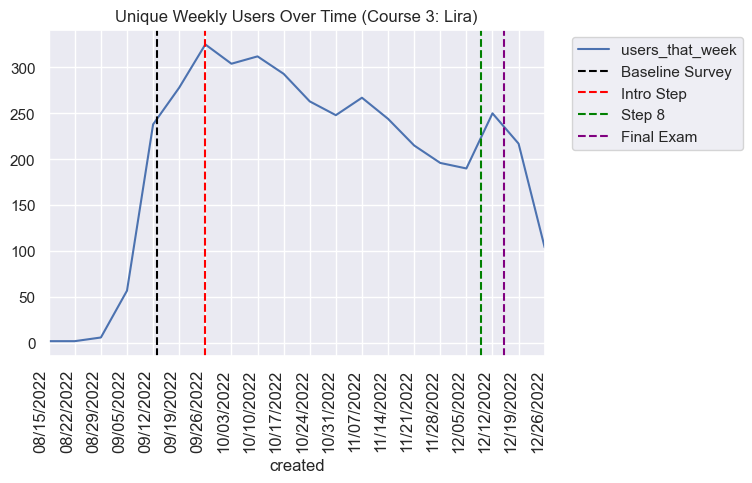

created
2022-08-15      2
2022-08-22      2
2022-08-29      6
2022-09-05     57
2022-09-12    238
2022-09-19    278
2022-09-26    325
2022-10-03    304
2022-10-10    312
2022-10-17    293
2022-10-24    263
2022-10-31    248
2022-11-07    267
2022-11-14    244
2022-11-21    215
2022-11-28    196
2022-12-05    190
2022-12-12    250
2022-12-19    217
2022-12-26    104
Freq: 7D, Name: user_id, dtype: int64

In [169]:
import matplotlib.dates as mdates

def show_unique_users_over_time(df):
    print("Enrolled Users:  ", df["user_id"].nunique())
    weekly_resample = df.resample("7D", on="created")

    plt.title("Unique Weekly Users Over Time (Course 3: Lira)")

    weekly_resample["user_id"].nunique().plot(label="users_that_week")
    #weekly_resample["user_id"].size().plot()

    #EVENT Lines
    #Baseline Survey
    plt.axvline(x = "09/13/2022", color = 'black', linestyle ="--", label = 'Baseline Survey')
    #into step
    plt.axvline(x = "09/26/2022", color = 'red', linestyle ="--", label = 'Intro Step')
    #label exam start
    plt.axvline(x = "12/09/2022", color = 'green', linestyle ="--", label = 'Step 8')
    #label exam start
    plt.axvline(x = "12/15/2022", color = 'purple', linestyle ="--", label = 'Final Exam')

    #Format dates on x axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.gcf().autofmt_xdate()
    plt.xticks(fontsize=12, rotation=90)

    #Format Legend
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    #show plot
    plt.show() 

    #Show Raw Data
    display(weekly_resample["user_id"].nunique())

show_unique_users_over_time(lira_responses_expanded)

# Correlation Analysis

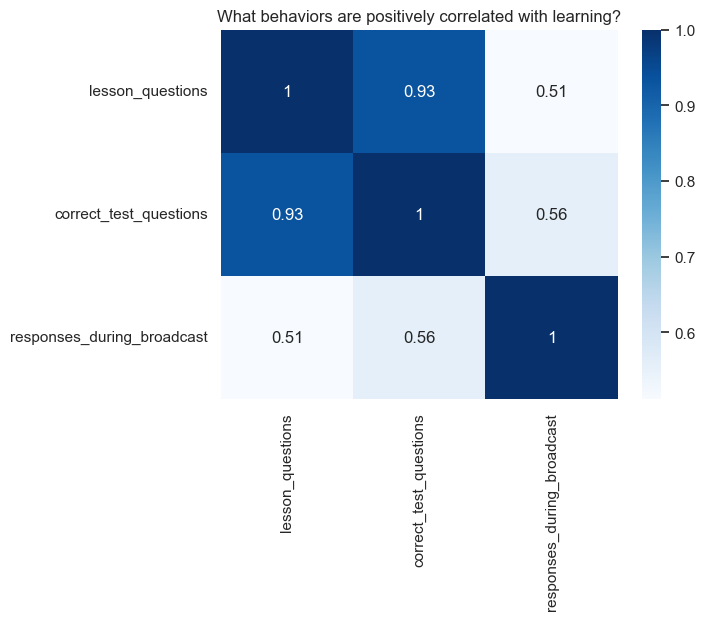

In [170]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline

corr = lira_learner_outcomes.corr()

plt.title("What behaviors are positively correlated with learning?")

sns.heatmap(corr, cmap="Blues", annot=True)
plt.show()

There is a very weak correlation between number of messages sent messages during broadcast time (active participation in broadcasts) and performance in test questions.

# Regression Analysis

The Regression analysis below shows that the coefficient for responses_during broadcast. The R squared value  (0.45) indicates that there responses during broadcast is moderately correlated with correct test questions. 



In [171]:
import statsmodels.api as sm

y = lira_learner_outcomes["correct_test_questions"] #outcome
X = lira_learner_outcomes["responses_during_broadcast"]  #explanatory variable
mod = sm.OLS(y, X) 
res = mod.fit()
print(res.summary())

                                   OLS Regression Results                                  
Dep. Variable:     correct_test_questions   R-squared (uncentered):                   0.476
Model:                                OLS   Adj. R-squared (uncentered):              0.475
Method:                     Least Squares   F-statistic:                              372.5
Date:                    Thu, 05 Oct 2023   Prob (F-statistic):                    1.64e-59
Time:                            20:02:52   Log-Likelihood:                         -1902.7
No. Observations:                     411   AIC:                                      3807.
Df Residuals:                         410   BIC:                                      3811.
Df Model:                               1                                                  
Covariance Type:                nonrobust                                                  
                                 coef    std err          t      P>|t|      [0.0

To help with interpretation, z score ID and DD. For each STDEV, 
Normalize with Z scores. 

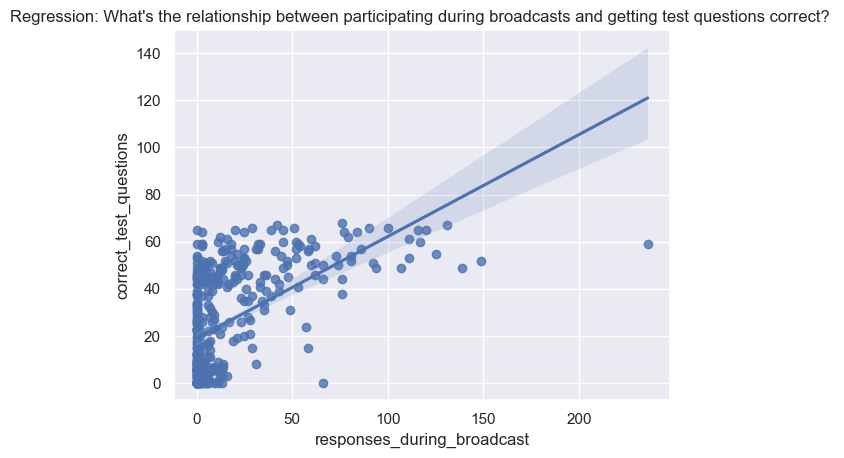

In [172]:
#Create Regression Plot of responses during broadcast vs correct test questions
sns.regplot(data=lira_learner_outcomes, x=X, y=y)
plt.title("Regression: What's the relationship between participating during broadcasts and getting test questions correct? ")
plt.show()

In [173]:
#certified
cert_of_innovation_users = pd.read_csv("/Users/ddbutler/Desktop/Repos/Yiya-Solutions-Analysis/yiya-completion-analysis/course3_feature_use/course3_certified_users.csv")
cert_of_innovation_users.sample(4, random_state=1)

,User ID
94,61555
78,32993
17,35139
100,39079


## Innovation Certificate Regression

This regression might be trash. I'm not sure how to interpret regressions with categorical outcomes. The negative coefficient is contradicting the correlation by negatively associating number of broadcast messages with building a prototype. 

In [174]:
#certificate of innovation learners
lira_learner_outcomes["received_innovation_cert"] =  lira_learner_outcomes.index.isin(cert_of_innovation_users["User ID"]).astype("int")
print("Lira users that received cert of innovation: ", lira_learner_outcomes["received_innovation_cert"].sum())

lira_learner_outcomes.sample(3)

Lira users that received cert of innovation:  46


,lesson_questions,correct_test_questions,responses_during_broadcast,received_innovation_cert
user_id,,,,
63580,2,3,0,0
59272,98,57,25,1
60097,21,11,0,0


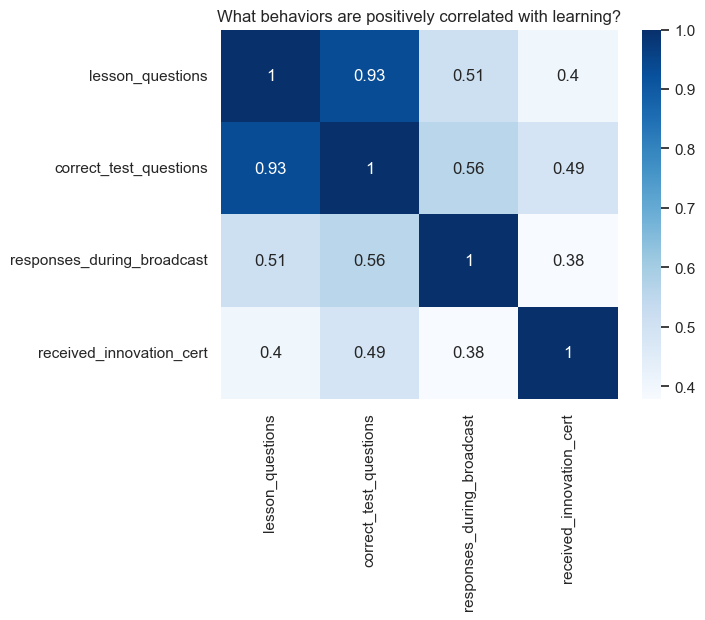

In [175]:
#Regression of broadcast activity and innovation cert

plt.title("What behaviors are positively correlated with learning?")
corr = lira_learner_outcomes.corr()
sns.heatmap(corr, cmap="Blues", annot=True)
plt.show()

In [176]:
#Multiple Logistic Regression
y = lira_learner_outcomes["received_innovation_cert"] 
X = lira_learner_outcomes["correct_test_questions"]
mod = sm.Logit(y, X) 
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.612342
         Iterations 5
                              Logit Regression Results                              
Dep. Variable:     received_innovation_cert   No. Observations:                  411
Model:                                Logit   Df Residuals:                      410
Method:                                 MLE   Df Model:                            0
Date:                      Thu, 05 Oct 2023   Pseudo R-squ.:                 -0.7470
Time:                              20:02:52   Log-Likelihood:                -251.67
converged:                             True   LL-Null:                       -144.06
Covariance Type:                  nonrobust   LLR p-value:                       nan
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
correct_test_questions    -0.0260   

# Export Data

In [177]:
processed_data_folder = "/Users/ddbutler/repos_new/yiya_data_analysis/data/processed/"

In [178]:
lira_responses.to_pickle(processed_data_folder + "lira_responses_paid_users.pkl")

# Summary

Most messages for learners registered with the Lira course were sent near the broadcast times. There is a very weak correlation between number of messages sent messages during broadcast time (active participation in broadcasts) and performance in test questions. However, there is a strong positive correlation between unique lesson questions attempted and test performance. This may suggest:
- Answering lesson questions without listening to the radio may be sufficient to perform well in tests
- Some learners may listen to broadcasts first to understand concepts and answer questions later

Limitations
- At time of analysis, the keys for the final exam in course 3 are unclear so it was not included. 

Future Work
- The next analysis will use num_practice_questions_during and num_practice_questions_beforeafter as analysis. 

# Code Tests

In [179]:
test_data = pd.DataFrame(
    {"created": ["2022-11-26T11:15:52.000", "2022-11-15T14:15:59.000", "2022-11-26T11:15:52.000"],
     "key": ["airscience-2022a/course/step-2-investigate/step-2-lesson-3/go-to-questions#q3-why-did-the-stick-pencil-inserted-in-the-bottle-of-rice-stones-lift-up-the-bottle",
             "yiya-airscience-tests-2021/take-step-1-test#q1",
             "yiya-airscience-tests-2021/take-step-1-test#q1"]}
    )

test_data["created"] = pd.to_datetime(test_data["created"]) 
#test_data
print(test_data["created"].dt.day_name())
print(cal_user_resposes_during_broadcast(test_data))


0    Saturday
1     Tuesday
2    Saturday
Name: created, dtype: object
1
